In [5]:
%matplotlib inline

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [87]:
def mnist_reshape_128(x, i_offset = 0, j_offset = 0):
    assert x.shape == (28 * 28,)
    image = x.reshape(28, 28)
    image = np.append(np.zeros((128 + 2, 28)), image, axis = 0)
    image = np.append(image, np.zeros((128 + 2, 28)), axis = 0)
    image = np.append(np.zeros((288, 128 + 2)), image, axis = 1)
    image = np.append(image, np.zeros((288, 128 + 2)), axis = 1)
    return image[128 + 16 - 64 - i_offset : 128 + 16 + 64 - i_offset, 128 + 16 - 64 - j_offset : 128 + 16 + 64 - j_offset]

def minmax(value,   #valeur a delimiter
           border): #limite min/max a ne pas depasser 
    value = max(value, -border)
    value = min(value, border)
    return value

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def softmax_label_to_value(softmax_label):
    y_num = 0
    for n in softmax_label:
        if n == np.max(softmax_label): 
            value = y_num
            break
        y_num += 1
    return value  

def one_hot_label_to_value(one_hot_label):
    y_num = 0
    for n in one_hot_label:
        if n == 1: 
            value = y_num
            break
        y_num += 1
    return value  

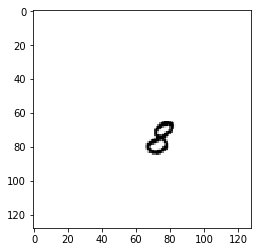

In [15]:
mnist_image_sample = mnist_reshape_128(mnist.train.images[5], 10,10)
plt.imshow(mnist_image_sample, cmap= 'gray_r')

# Learning a classifier

In [100]:
batch_size = 1500
iterations = 400
alpha = 0.1
vector_size = 128*128

In [101]:
weights = tf.Variable(tf.random_normal([vector_size,10], stddev=0.1), name='weights')
x_train = tf.placeholder(tf.float32, shape=[None,vector_size], name='t_train')
labels = tf.placeholder(tf.float32, shape=[None,10], name='labels')

In [62]:
sess = tf.Session()

In [102]:
hypo = tf.nn.softmax(tf.matmul(x_train, weights))
cost = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=hypo)
optimizer = tf.train.AdamOptimizer(alpha).minimize(cost)

init = tf.global_variables_initializer()
sess.run(init)

In [103]:
for it in range(iterations):
    batch = mnist.test.next_batch(batch_size)
    x_list, label_list = [],[]
    count_example = 0
    for example in batch[0]:
        i_off, j_off = minmax(int(np.random.randn() * 15),100), minmax(int(np.random.randn() * 15),100)
        image = mnist_reshape_128(example, i_off, j_off)
        x_list += [np.ravel(image)]
        label_list += [batch[1][count_example]]
        count_example += 1
        
    sess.run(optimizer, {x_train: x_list, labels: label_list})
    
    if it%20==0: print(it,'/',iterations)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


In [59]:
sess.close()

# Evaluating the classifier

In [104]:
eval_batch_size = 1000
iterations = 100
vector_size = 128*128

In [105]:
weights_values = weights.eval(session=sess)

In [106]:
correct_numb = 0
for it in range(iterations):
    eval_batch = mnist.test.next_batch(eval_batch_size)
    example_numb = 0
    for example in eval_batch[0]:
        i_off, j_off = minmax(int(np.random.randn() * 15),100), minmax(int(np.random.randn() * 15),100)
        image = mnist_reshape_128(example, i_off, j_off)
        cat_off = eval_batch[1][example_numb]
        cat_hat = softmax(np.dot(np.ravel(image), weights_values))
        if one_hot_label_to_value(cat_off) == softmax_label_to_value(cat_hat):
            correct_numb += 1
        example_numb += 1
    if it%10 == 0: print(it)
percent_correct = (correct_numb*100)/(iterations*eval_batch_size)
print(percent_correct)

0
10
20
30
40
50
60
70
80
90
20.61
